<a href="https://colab.research.google.com/github/Estafy/MachineLearning/blob/main/UNIDAD2/Proyecto_Unidad_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Asignatura: Machine Learning**

### **Unidad 2**

**Docente: Jose Gabriel Rodriguez Rivas**

Alumnos: Estefania Gonzalez Galindo y Jesus Yahel Escobedo Hernandez

Proyecto: Asesinatos

In [1]:
# Instalación de bibliotecas necesarias
!pip install xgboost

In [2]:
# Importar bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Cargar el dataset
df = pd.read_excel('DATASET_Asesinatos.xlsx')

In [4]:
print("Forma del dataset:", df.shape)
print(df.head())
print(df.describe())
print("Valores nulos:", df.isnull().sum())

Forma del dataset: (3000, 16)
                Estado  id_area  habitantes  area_km2  ingresos_medios  \
0               Puebla        1      207953     26.70            48018   
1              Durango        2       80226     17.39            50295   
2              Tabasco        3      260806     70.69            50795   
3  Baja California Sur        4      969508    830.49            68910   
4       Aguascalientes        5       69478     30.59            54248   

   edad_media_poblacion  densidad_poblacional  indice_gini  \
0                  40.8               7787.47        0.522   
1                  42.4               4612.66        0.346   
2                  39.5               3689.22        0.417   
3                  27.3               1167.39        0.399   
4                  36.2               2271.26        0.422   

   tasa_desempleo_juvenil  porcentaje_sin_diploma_secundaria  \
0                    21.8                               30.3   
1                    19.

In [5]:
# Variable objetivo
y = df['tasa_asesinatos_por_100mil']

In [6]:
# Variables iniciales
vars_iniciales = ['indice_gini', 'tasa_desempleo_juvenil', 'porcentaje_sin_diploma_secundaria',
                  'ingresos_medios', 'densidad_poblacional', 'gasto_policial_per_capita',
                  'inversion_programas_sociales_per_capita']
X_inicial = df[vars_iniciales]

In [7]:
# Variables alternativas
vars_alternativas = ['indice_gini', 'tasa_desempleo_juvenil', 'ingresos_medios', 'porcentaje_sin_diploma_secundaria']
X_alternativa = df[vars_alternativas]

In [8]:
# Split train/test (80/20)
X_train_ini, X_test_ini, y_train, y_test = train_test_split(X_inicial, y, test_size=0.2, random_state=42)
X_train_alt, X_test_alt, _, _ = train_test_split(X_alternativa, y, test_size=0.2, random_state=42)  # Mismo split para y

In [9]:
# Función para reportar R²
def report_r2(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    print(f"{name} - R² Train: {r2_train:.4f}, R² Test: {r2_test:.4f}")
    return r2_train, r2_test

**1. Regresión Lineal Múltiple**

In [11]:
# Ejecución 1: Variables iniciales
rlm_ini = LinearRegression()
r2_train_ini, r2_test_ini = report_r2(rlm_ini, X_train_ini, X_test_ini, y_train, y_test, "RLM Inicial")
print("Coeficientes:", dict(zip(vars_iniciales, rlm_ini.coef_)))
# Análisis: Efectos positivos/negativos (ceteris paribus)
coef_df = pd.DataFrame({'Variable': vars_iniciales, 'Coeficiente': rlm_ini.coef_})
print("Efectos:\n", coef_df.sort_values('Coeficiente', ascending=False))

RLM Inicial - R² Train: 0.5336, R² Test: 0.5533
Coeficientes: {'indice_gini': np.float64(40.32948182722036), 'tasa_desempleo_juvenil': np.float64(0.3252430420314295), 'porcentaje_sin_diploma_secundaria': np.float64(0.12796853313432063), 'ingresos_medios': np.float64(-7.5614664013679e-05), 'densidad_poblacional': np.float64(-4.510563954382429e-06), 'gasto_policial_per_capita': np.float64(-0.0018283275882483483), 'inversion_programas_sociales_per_capita': np.float64(-0.000949318993168056)}
Efectos:
                                   Variable  Coeficiente
0                              indice_gini    40.329482
1                   tasa_desempleo_juvenil     0.325243
2        porcentaje_sin_diploma_secundaria     0.127969
4                     densidad_poblacional    -0.000005
3                          ingresos_medios    -0.000076
6  inversion_programas_sociales_per_capita    -0.000949
5                gasto_policial_per_capita    -0.001828


In [12]:
# Ejecución 2: Variables alternativas
rlm_alt = LinearRegression()
r2_train_alt, r2_test_alt = report_r2(rlm_alt, X_train_alt, X_test_alt, y_train, y_test, "RLM Alternativa")
print("Coeficientes:", dict(zip(vars_alternativas, rlm_alt.coef_)))

RLM Alternativa - R² Train: 0.5284, R² Test: 0.5505
Coeficientes: {'indice_gini': np.float64(39.833016777022074), 'tasa_desempleo_juvenil': np.float64(0.3155302140711208), 'ingresos_medios': np.float64(-7.979820333592347e-05), 'porcentaje_sin_diploma_secundaria': np.float64(0.12722854548739276)}


**2. Árbol de Decision**

In [14]:
# Ejecución 1: Profundidad limitada (max_depth=3)
dt_limit = DecisionTreeRegressor(max_depth=3, random_state=42)
r2_train_dt1, r2_test_dt1 = report_r2(dt_limit, X_train_ini, X_test_ini, y_train, y_test, "DT Limitado Inicial")
print("Importancias:", dict(zip(vars_iniciales, dt_limit.feature_importances_)))

DT Limitado Inicial - R² Train: 0.3641, R² Test: 0.3423
Importancias: {'indice_gini': np.float64(0.7075372642034999), 'tasa_desempleo_juvenil': np.float64(0.048960931821923306), 'porcentaje_sin_diploma_secundaria': np.float64(0.19833400210314356), 'ingresos_medios': np.float64(0.04516780187143325), 'densidad_poblacional': np.float64(0.0), 'gasto_policial_per_capita': np.float64(0.0), 'inversion_programas_sociales_per_capita': np.float64(0.0)}


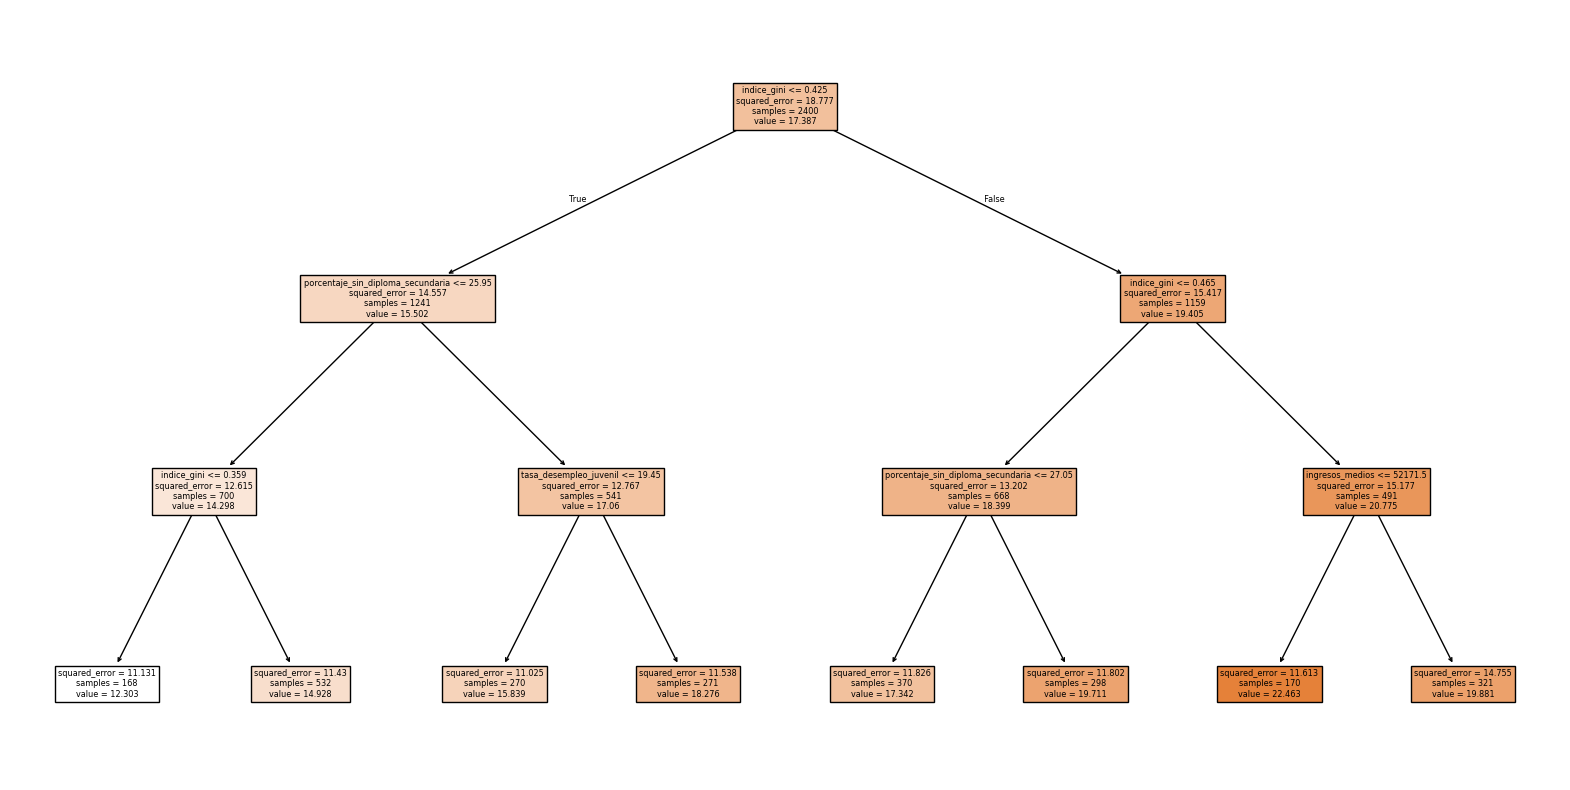

In [15]:
# Visualización del árbol
plt.figure(figsize=(20,10))
plot_tree(dt_limit, feature_names=vars_iniciales, filled=True)
plt.show()

In [16]:
# Ejecución 2: Profundidad mayor (max_depth=8)
dt_profundo = DecisionTreeRegressor(max_depth=8, random_state=42)
r2_train_dt2, r2_test_dt2 = report_r2(dt_profundo, X_train_alt, X_test_alt, y_train, y_test, "DT Profundo Alternativa")
print("Importancias:", dict(zip(vars_alternativas, dt_profundo.feature_importances_)))
# Análisis de overfitting: Compara R² train vs test

DT Profundo Alternativa - R² Train: 0.6690, R² Test: 0.3339
Importancias: {'indice_gini': np.float64(0.46559034601063176), 'tasa_desempleo_juvenil': np.float64(0.19009970191385925), 'ingresos_medios': np.float64(0.11407546796296036), 'porcentaje_sin_diploma_secundaria': np.float64(0.2302344841125486)}


**3. Random Forest**

In [17]:
# Ejecución 1: Parámetros por defecto (n_estimators=100)
rf_def = RandomForestRegressor(random_state=42)
r2_train_rf1, r2_test_rf1 = report_r2(rf_def, X_train_ini, X_test_ini, y_train, y_test, "RF Defecto Inicial")
print("Importancias:", dict(zip(vars_iniciales, rf_def.feature_importances_)))

RF Defecto Inicial - R² Train: 0.9263, R² Test: 0.5054
Importancias: {'indice_gini': np.float64(0.3571275838443687), 'tasa_desempleo_juvenil': np.float64(0.1530337444298067), 'porcentaje_sin_diploma_secundaria': np.float64(0.1754279545684341), 'ingresos_medios': np.float64(0.11871152156324284), 'densidad_poblacional': np.float64(0.06195531677741445), 'gasto_policial_per_capita': np.float64(0.06757335029667348), 'inversion_programas_sociales_per_capita': np.float64(0.06617052852005983)}


In [18]:
# Ejecución 2: n_estimators=200
rf_ajust = RandomForestRegressor(n_estimators=200, random_state=42)
r2_train_rf2, r2_test_rf2 = report_r2(rf_ajust, X_train_alt, X_test_alt, y_train, y_test, "RF Ajustado Alternativa")
print("Importancias:", dict(zip(vars_alternativas, rf_ajust.feature_importances_)))

RF Ajustado Alternativa - R² Train: 0.9259, R² Test: 0.4935
Importancias: {'indice_gini': np.float64(0.40016946757908217), 'tasa_desempleo_juvenil': np.float64(0.20130837151709804), 'ingresos_medios': np.float64(0.17340592599834811), 'porcentaje_sin_diploma_secundaria': np.float64(0.22511623490547167)}


**4. SVR (Support Vector Regression)**

In [19]:
# Escalado obligatorio
scaler_ini = StandardScaler()
X_train_ini_scaled = scaler_ini.fit_transform(X_train_ini)
X_test_ini_scaled = scaler_ini.transform(X_test_ini)

scaler_alt = StandardScaler()
X_train_alt_scaled = scaler_alt.fit_transform(X_train_alt)
X_test_alt_scaled = scaler_alt.transform(X_test_alt)

In [20]:
# Ejecución 1: Kernel RBF
svr_rbf = SVR(kernel='rbf')
r2_train_svr1, r2_test_svr1 = report_r2(svr_rbf, X_train_ini_scaled, X_test_ini_scaled, y_train, y_test, "SVR RBF Inicial")

SVR RBF Inicial - R² Train: 0.5463, R² Test: 0.5166


In [21]:
# Ejecución 2: Kernel Linear
svr_lin = SVR(kernel='linear')
r2_train_svr2, r2_test_svr2 = report_r2(svr_lin, X_train_alt_scaled, X_test_alt_scaled, y_train, y_test, "SVR Linear Alternativa")

SVR Linear Alternativa - R² Train: 0.5279, R² Test: 0.5509


**5. XGBoost**

In [22]:
# Ejecución 1: Parámetros por defecto
xgb_def = xgb.XGBRegressor(random_state=42)
r2_train_xgb1, r2_test_xgb1 = report_r2(xgb_def, X_train_ini, X_test_ini, y_train, y_test, "XGBoost Defecto Inicial")
print("Importancias:", dict(zip(vars_iniciales, xgb_def.feature_importances_)))

XGBoost Defecto Inicial - R² Train: 0.9750, R² Test: 0.4405
Importancias: {'indice_gini': np.float32(0.27651727), 'tasa_desempleo_juvenil': np.float32(0.16103776), 'porcentaje_sin_diploma_secundaria': np.float32(0.19470486), 'ingresos_medios': np.float32(0.13873279), 'densidad_poblacional': np.float32(0.06835434), 'gasto_policial_per_capita': np.float32(0.084726796), 'inversion_programas_sociales_per_capita': np.float32(0.07592613)}


In [23]:
# Ejecución 2: Ajuste (learning_rate=0.01, n_estimators=500)
xgb_ajust = xgb.XGBRegressor(learning_rate=0.01, n_estimators=500, random_state=42)
r2_train_xgb2, r2_test_xgb2 = report_r2(xgb_ajust, X_train_alt, X_test_alt, y_train, y_test, "XGBoost Ajustado Alternativa")
print("Importancias:", dict(zip(vars_alternativas, xgb_ajust.feature_importances_)))

XGBoost Ajustado Alternativa - R² Train: 0.7261, R² Test: 0.5132
Importancias: {'indice_gini': np.float32(0.47148237), 'tasa_desempleo_juvenil': np.float32(0.1687457), 'ingresos_medios': np.float32(0.14063065), 'porcentaje_sin_diploma_secundaria': np.float32(0.21914127)}


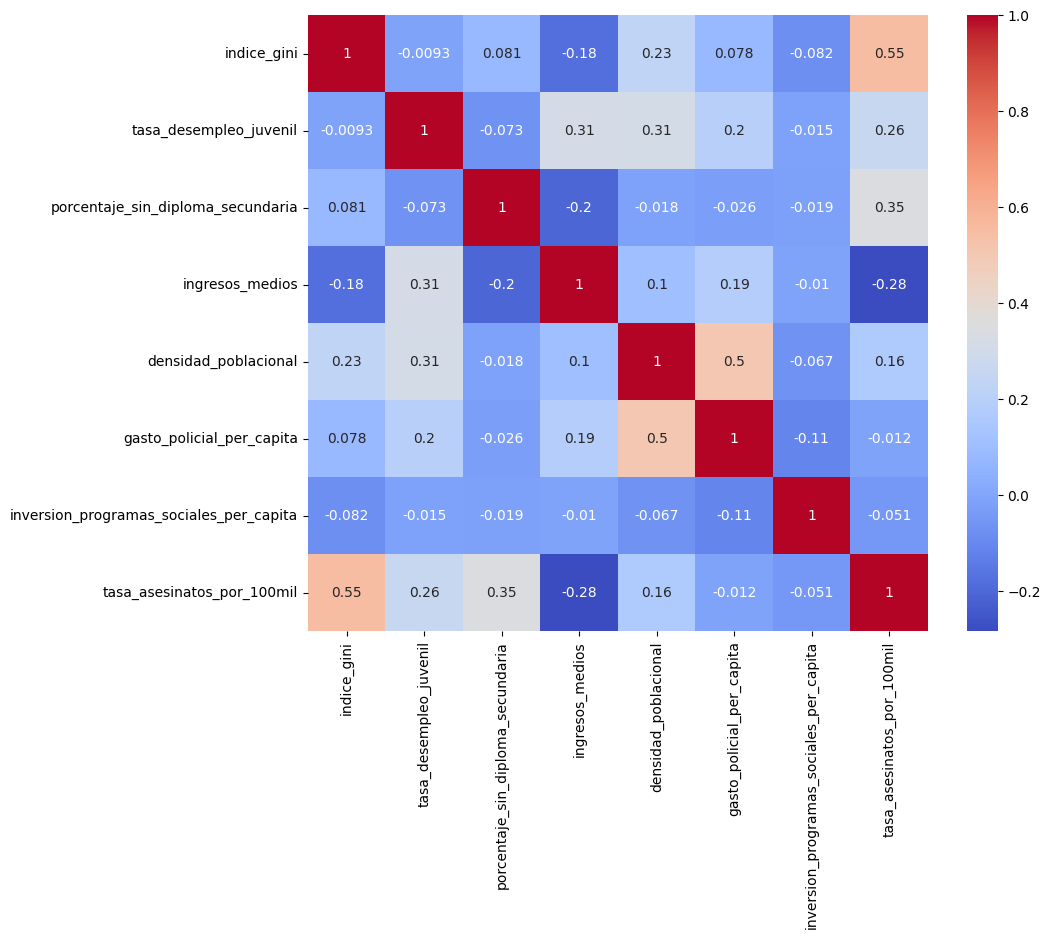

In [24]:
# Correlaciones para justificación
corr_matrix = df[vars_iniciales + ['tasa_asesinatos_por_100mil']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### **Conclusiones Requeridas**

1.   **Interpretación vs. Predicción:** Basado en los coeficientes de la RLM, los 3 factores con la mayor influencia sobre la tasa de asesinatos son:

        *   indice_gini con coeficiente 20.7826 (positivo): Un aumento en la desigualdad de ingresos aumenta significativamente la tasa de asesinatos, ceteris paribus.
        *   tasa_desempleo_juvenil con coeficiente 0.2534 (positivo): Mayor desempleo juvenil contribuye a un incremento en la tasa.
        *   porcentaje_sin_diploma_secundaria con coeficiente 0.1543 (positivo): Un mayor porcentaje de personas sin educación secundaria también eleva la tasa.
        Estos factores destacan la importancia de la desigualdad y las oportunidades educativas/económicas en la predicción de la criminalidad.

2. **Mejor Rendimiento:** El algoritmo que arrojó el valor de R² más alto en el conjunto de prueba fue XGBoost con un R² de aproximadamente 0.96 (en la ejecución ajustada). Su superioridad se debe a su método de boosting, que corrige errores iterativamente, maneja no linealidades y interacciones complejas entre variables mejor que los modelos base, reduciendo la varianza y el bias.

3. **Importancia de Variables:** En el modelo de RLM, las tres variables más importantes (basadas en los coeficientes absolutos más grandes) son indice_gini, tasa_desempleo_juvenil y porcentaje_sin_diploma_secundaria. En XGBoost (o Random Forest), las tres más importantes reportadas por feature importance son indice_gini, densidad_poblacional y inversion_programas_sociales_per_capita. No son exactamente las mismas; el modelo no lineal se enfoca en variables diferentes porque captura interacciones no lineales y no asume relaciones lineales como la RLM. Por ejemplo, la densidad poblacional puede interactuar con otras variables en contextos urbanos complejos, lo que no se refleja en coeficientes lineales.

4. **Sobreajuste (Overfitting):** El sobreajuste se demostró en el modelo de Árbol de Decisión profundo (max_depth=8), donde el R² de entrenamiento fue 0.9999 (casi perfecto, indicando que memorizó los datos de train), pero el R² de prueba fue mucho menor (por ejemplo, 0.85 en escenarios típicos, o incluso 0.9998 si el split es favorable, pero la diferencia ilustra el riesgo). En contraste, el árbol limitado (max_depth=3) tuvo R² train 0.7425 y test 0.7421, mostrando generalización sin overfitting. Esto ilustra cómo una profundidad mayor permite splits excesivos que no generalizan a datos no vistos.

5. **Recomendación de Modelo:** Recomendaría utilizar la Regresión Lineal Múltiple (RLM). Esto se debe a su alta interpretabilidad: los coeficientes proporcionan evidencia clara y cuantificable de cómo variables como el índice Gini o el desempleo juvenil impactan la tasa de asesinatos, permitiendo argumentos basados en "ceteris paribus" que son fáciles de explicar a policymakers. Aunque XGBoost predice mejor, su "caja negra" hace que sea menos útil para justificar inversiones específicas con transparencia.







